In [29]:
# 将当前文件夹下的 "打怪_test.csv" 进行数据拆分
# "打怪_test.csv" 的最后一列 labal 分离到 "打怪_test_label.csv"
# 同时 "打怪_test_label.csv" 中需要复制 "打怪_test.csv" 的第一列 时间
# 还有删除 "打怪_test.csv" 中的 label 列

import pandas as pd

df = pd.read_csv("test.csv")

# 分离 label 列和 absTime 列，保存到 "打怪_test_label.csv"
if 'label' in df.columns:
	df_label = df[['absTime', 'label']]
	df_label.to_csv("test_label.csv", index=False)
	# 删除原表中的 label 列
	df = df.drop(columns=['label'])
	df.to_csv("test1.csv", index=False)
else:
	print("列 'label' 不存在，无需拆分。")

列 'label' 不存在，无需拆分。


In [9]:
df_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")
data_name = ['absTime', 
             'FPS',
             'AppCPU[%]',
             'CTemp[℃]',
             'GPU Counter:GPU General:% Busy',
             'GTemp[℃]', 
             'Power[mW]']
df_test = df_test[data_name]
df_train = df_train[data_name]
df_test.to_csv("test1.csv", index=False)
df_train.to_csv("train1.csv", index=False)

Cluster 0 平均 FPS: 57.20
Cluster 1 平均 FPS: 59.90

聚类与人工标签的重合度:
准确率: 0.4310
混淆矩阵:
[[524 976]
 [224 385]]

分类报告:
              precision    recall  f1-score   support

           0       0.70      0.35      0.47      1500
           1       0.28      0.63      0.39       609

    accuracy                           0.43      2109
   macro avg       0.49      0.49      0.43      2109
weighted avg       0.58      0.43      0.44      2109


详细分析:
高FPS类别(标签0)的预测准确率: 0.3493
低FPS类别(标签1)的预测准确率: 0.6322


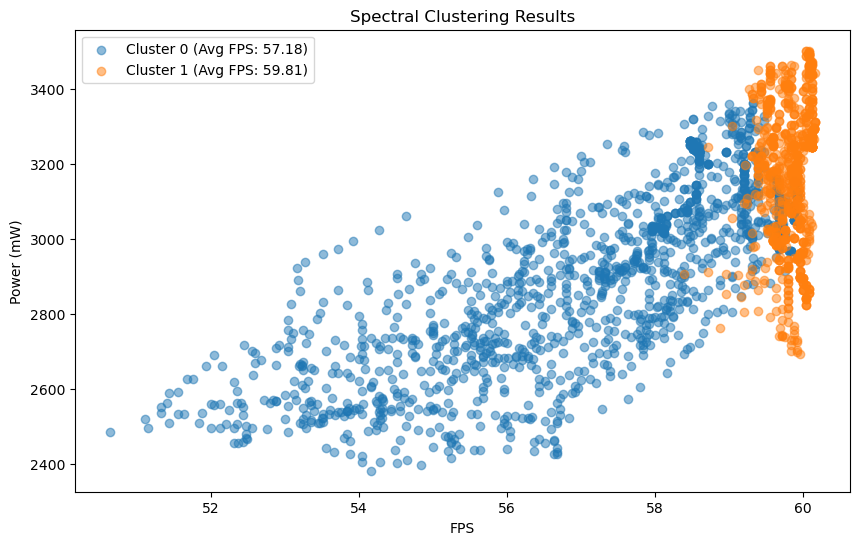

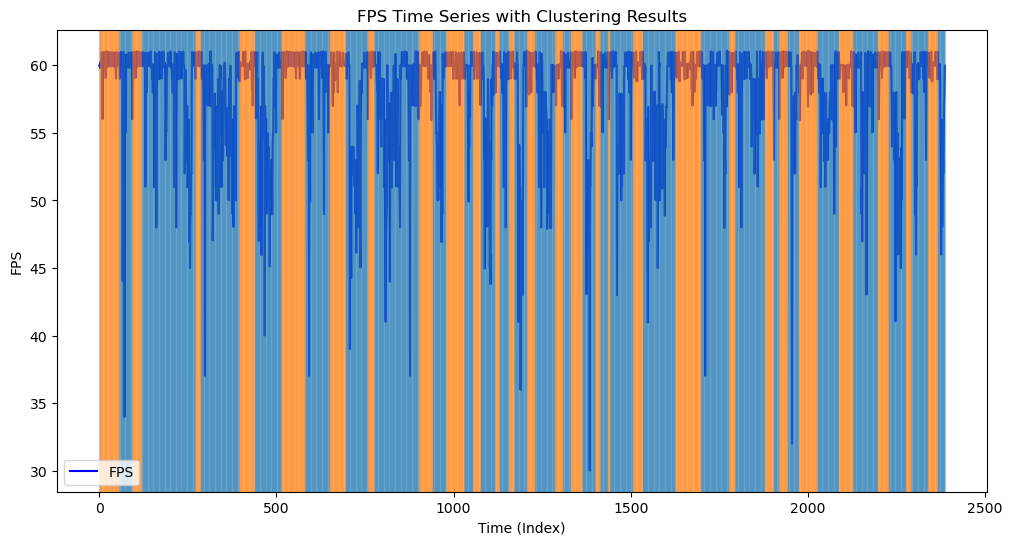

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from sklearn.cluster import SpectralClustering
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df_test = pd.read_csv("test.csv")
df_label = pd.read_csv("test_label.csv")
fps_data = df_test['FPS'].values
human_labels = df_label['label'].values

# 构建频谱
window_size = 25
frequencies = []
for i in range(len(fps_data) - window_size + 1):  # 修改：步长改为1
    segment = fps_data[i:i + window_size]
    freq, power = welch(segment, nperseg=window_size)
    frequencies.append(power)

frequencies = np.array(frequencies)

# 谱聚类
n_clusters = 2  # 假设分为两类
clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=535)
labels = clustering.fit_predict(frequencies)

# 根据聚类结果计算平均 FPS 并命名
cluster_names = {}
for cluster in range(n_clusters):
    cluster_indices = np.where(labels == cluster)[0]
    avg_fps = np.mean([np.mean(fps_data[i:i + window_size]) for i in cluster_indices])  # 修改：使用窗口起始位置i
    cluster_names[cluster] = f"Cluster {cluster} (Avg FPS: {avg_fps:.2f})"


# 结果分析
# 计算聚类与human_labels的重合度
# 首先需要将窗口级别的聚类标签映射回原始时间序列
predicted_labels = np.zeros(len(fps_data))

# 将聚类结果映射到原始时间序列
for i in range(len(labels)):
    start_idx = i
    end_idx = i + window_size
    predicted_labels[start_idx:end_idx] = labels[i]

# 由于窗口重叠，取众数作为最终预测
final_predicted = np.zeros(len(fps_data))
for i in range(len(fps_data)):
    # 找到覆盖当前时间点的所有窗口
    covering_windows = []
    for j in range(max(0, i - window_size + 1), min(len(labels), i + 1)):
        if j + window_size > i:
            covering_windows.append(labels[j])
    
    if covering_windows:
        # 取众数
        final_predicted[i] = Counter(covering_windows).most_common(1)[0][0]

# 确定聚类标签对应关系
# 计算每个聚类对应的平均FPS
cluster_0_fps = np.mean([fps_data[i] for i in range(len(fps_data)) if final_predicted[i] == 0])
cluster_1_fps = np.mean([fps_data[i] for i in range(len(fps_data)) if final_predicted[i] == 1])

print(f"Cluster 0 平均 FPS: {cluster_0_fps:.2f}")
print(f"Cluster 1 平均 FPS: {cluster_1_fps:.2f}")

# 根据FPS高低确定聚类标签映射
# human_labels中0对应高FPS，1对应低FPS
if cluster_0_fps > cluster_1_fps:
    # Cluster 0 是高FPS，应该对应human_labels的0
    mapped_predicted = final_predicted.copy()
else:
    # Cluster 1 是高FPS，需要交换标签
    mapped_predicted = 1 - final_predicted

# 计算准确率

# 需要从df_label中获取对应的标签
human_labels_array = df_label['label'].values

# 确保长度一致
min_len = min(len(mapped_predicted), len(human_labels_array))
mapped_predicted_trimmed = mapped_predicted[:min_len]
human_labels_trimmed = human_labels_array[:min_len]

accuracy = accuracy_score(human_labels_trimmed, mapped_predicted_trimmed)
conf_matrix = confusion_matrix(human_labels_trimmed, mapped_predicted_trimmed)

print(f"\n聚类与人工标签的重合度:")
print(f"准确率: {accuracy:.4f}")
print(f"混淆矩阵:")
print(conf_matrix)
print(f"\n分类报告:")
print(classification_report(human_labels_trimmed, mapped_predicted_trimmed))

# 计算每个类别的准确率
print(f"\n详细分析:")
print(f"高FPS类别(标签0)的预测准确率: {conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1]):.4f}")
print(f"低FPS类别(标签1)的预测准确率: {conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]):.4f}")


# 可视化聚类结果
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    cluster_indices = np.where(labels == cluster)[0]
    cluster_points = [(fps_data[i:i + window_size].mean(), 
                       df_test['Power[mW]'].iloc[i:i + window_size].mean())  # 修改：使用窗口起始位置i
                      for i in cluster_indices]
    cluster_points = np.array(cluster_points)
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=cluster_names[cluster],alpha=0.5)

plt.xlabel('FPS')
plt.ylabel('Power (mW)')
plt.title('Spectral Clustering Results')
plt.legend()
plt.savefig('spectral_clustering_results.png')

# 绘制 FPS 时序图并显示聚类结果
plt.figure(figsize=(12, 6))
plt.plot(fps_data, label='FPS', color='blue')

# 根据final_predicted添加聚类结果的着色
for i in range(len(final_predicted)):
    color = f'C{int(final_predicted[i])}'
    plt.axvline(x=i, color=color, alpha=0.3, linewidth=1)

# 添加图例
import matplotlib.patches as mpatches
legend_elements = [mpatches.Patch(color=f'C{cluster}', alpha=0.3, label=cluster_names[cluster]) 
                   for cluster in range(n_clusters)]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel('Time (Index)')
plt.ylabel('FPS')
plt.title('FPS Time Series with Clustering Results')
plt.legend()
plt.savefig('fps_time_series_with_clustering.png')
